# Visualization of states

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import yaml
import seaborn as sns

from kvae.model.model import KVAE
from kvae.utils.config import KVAEConfig
from kvae.train.utils import parse_device, build_dataloaders, seed_all_modules

## Definitions

In [2]:
def load_checkpoint(checkpoint_path, device='auto', kvae_kwargs=None):
    """
    Load a trained KVAE model from checkpoint.
    
    Args:
        checkpoint_path: Path to checkpoint file (.pt)
        device: Device to load model on ('auto', 'cuda', 'cpu', 'mps')
    
    Returns:
        model: Loaded KVAE model
        checkpoint: Full checkpoint dictionary with training info
        device: The actual device being used
    """
    checkpoint_path = Path(checkpoint_path)
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    device = parse_device(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Initialize model with config
    kwargs = kvae_kwargs if kvae_kwargs is not None else {}
    cfg = KVAEConfig(**kwargs)
    model = KVAE(cfg).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state'])
    model.eval()
    
    print(f"✓ Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"  Train loss: {checkpoint['train_loss']:.6f}")
    print(f"  Val loss: {checkpoint['val_loss']:.6f}")
    
    return model, checkpoint, device


def load_model_val_loader(checkpoint_path, config_path=None, device='cpu', kvae_kwargs=None):
    # Load config from the run directory
    if config_path is None:
        config_path = Path(checkpoint_path).parent.parent / "config.yaml"

    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    kvae_config = config.get('kvae', {})
    if kvae_kwargs is not None:
        kvae_config.update(kvae_kwargs)
    
    # Load model
    model, _, device = load_checkpoint(checkpoint_path, device=device, kvae_kwargs=kvae_config)

    # Load data
    _, val_loader = build_dataloaders(
        config['dataset'], 
        batch_size=config['training']['batch_size']
    )

    return model, val_loader, device

## Full reconstruction

In [92]:
runs_path = Path("../runs/20251213-131228")
checkpoint_path = runs_path / "checkpoints/kvae-best.pt"
device = 'cpu'

model_ori, val_loader, device = load_model_val_loader(checkpoint_path, device='cpu', kvae_kwargs={'dynamics_model': 'lstm'})

# batch = next(iter(val_loader))
# with open('kvae_skvae_comparison_states_batch.pt', 'wb') as f:
#     torch.save(batch, f)
with open('kvae_skvae_comparison_states_batch.pt', 'rb') as f:
    batch = torch.load(f)

✓ Loaded checkpoint from epoch 100
  Train loss: 4.088638
  Val loss: 4.011723


In [63]:
outputs_ori = model_ori(batch['images'].to(device))

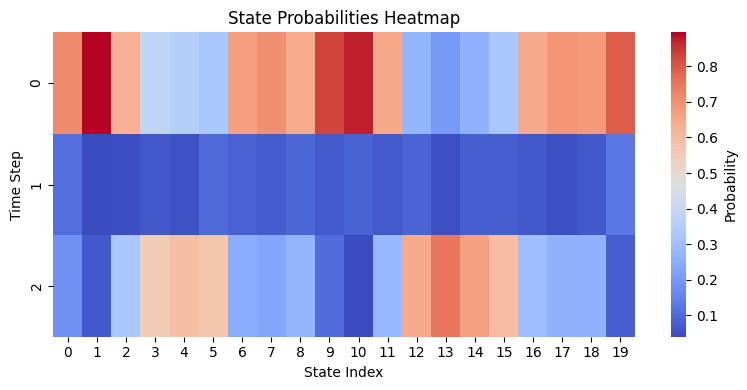

In [64]:
element_idx = 0
outputs = outputs_ori

states = outputs['state_probs'][element_idx, ...].cpu().detach().numpy()  # Shape: (T, K)
# Plot heatmap of state probabilities
plt.figure(figsize=(8, 4))
sns.heatmap(states.T, cmap="coolwarm", cbar_kws={"label": "Probability"})
plt.xlabel("State Index")
plt.ylabel("Time Step")
plt.title("State Probabilities Heatmap")
plt.tight_layout()
plt.show()


In [65]:
runs_path = Path("../runs/skvae-20251215-234708")
checkpoint_path = runs_path / "checkpoints/kvae-best.pt"
device = 'cpu'

model_new, val_loader, device = load_model_val_loader(checkpoint_path, config_path=runs_path / "config_MODIFIED.yaml", device='cpu')
outputs_new = model_new(batch['images'].to(device))

✓ Loaded checkpoint from epoch 89
  Train loss: 4.873523
  Val loss: 4.959289


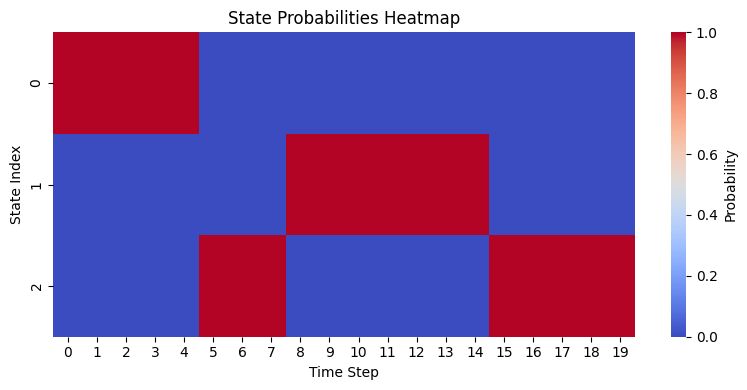

In [66]:
element_idx = 0
outputs = outputs_new

states = outputs['state_probs'][element_idx, ...].cpu().detach().numpy()  # Shape: (T, K)
# Plot heatmap of state probabilities
plt.figure(figsize=(8, 4))
sns.heatmap(states.T, cmap="coolwarm", cbar_kws={"label": "Probability"})
plt.xlabel("Time Step")
plt.ylabel("State Index")
plt.title("State Probabilities Heatmap")
plt.tight_layout()
plt.show()




## Plot states

In [67]:
def plot_images_and_states(images, states):
    T = images.shape[0]
    C = images.shape[1]

    # Create figure with 2 subplots vertically aligned
    fig, (ax_img, ax_heat) = plt.subplots(2, 1, figsize=(12, 3), 
                                        gridspec_kw={'height_ratios': [1, 2]})

    # Plot image sequence as tiled frames
    # Concatenate frames horizontally
    if C == 1:
        # Grayscale - squeeze channel dimension
        tiled_images = np.concatenate([images[t, 0] for t in range(T)], axis=1)
        ax_img.imshow(tiled_images, cmap='gray', aspect='auto')
    else:
        # Color images
        tiled_images = np.concatenate([images[t].transpose(1, 2, 0) for t in range(T)], axis=1)
        ax_img.imshow(tiled_images, aspect='auto')

    # ax_img.set_xlabel("Time Step")
    ax_img.set_ylabel("Pixels")
    ax_img.axis('off')
    ax_img.set_title("Image Sequence")
    ax_img.set_xticks(np.arange(T) * images.shape[2] + images.shape[2] / 2)
    ax_img.set_xticklabels(range(T))

    # Plot state probabilities heatmap
    sns.heatmap(states.T, cmap="coolwarm", cbar_kws={"label": "Probability"}, ax=ax_heat)
    ax_heat.set_xlabel("Time Step")
    ax_heat.set_ylabel("State Index")
    ax_heat.collections[0].colorbar.remove()
    # ax_heat.set_title("State Probabilities Heatmap")

    plt.tight_layout()
    plt.show()

In [68]:
def plot_output_element(outputs, batch, element_idx):
    # Get images and states
    images = batch['images'][element_idx].cpu().detach().numpy()  # Shape: (T, C, H, W)
    states = outputs['state_probs'][element_idx].cpu().detach().numpy()  # Shape: (T, K)
    plot_images_and_states(images, states)

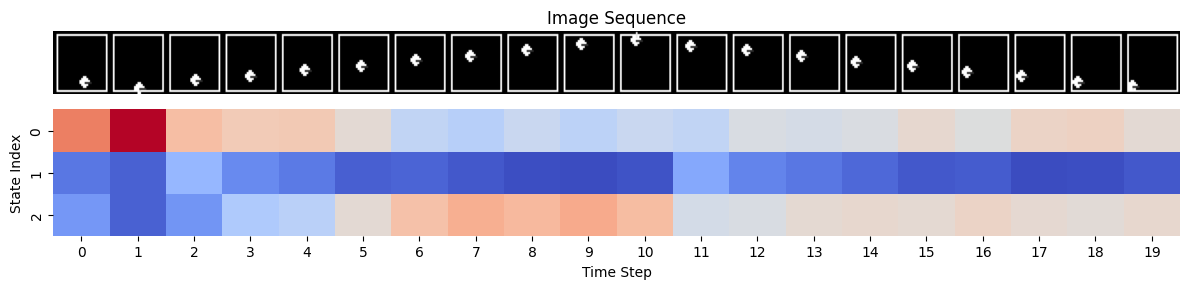

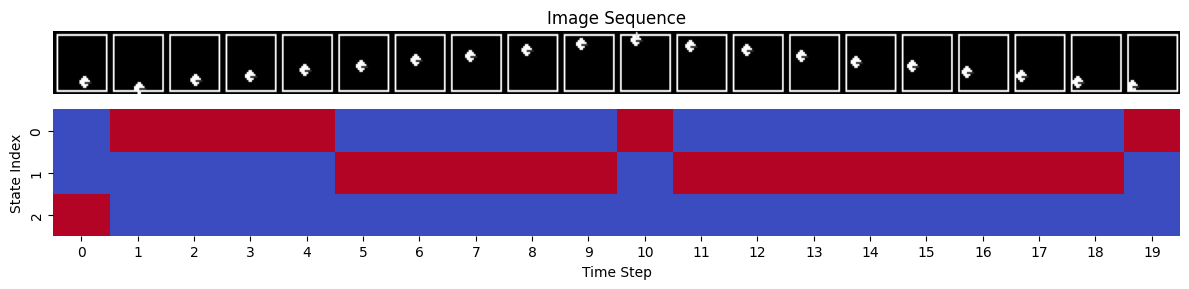

In [ ]:
element_idx = 1
plot_output_element(outputs_ori, batch, element_idx)
plot_output_element(outputs_new, batch, element_idx)